In [1]:
import pandas as pd
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
import time
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder

In [2]:
train_root='/home/yash/Downloads/train_av'
test_root='/home/yash/Downloads/test_av'
sample_root='/home/yash/Downloads/sample_av'
sample_demand=pd.read_csv(os.path.join(sample_root,'demand_forecast.csv'))
sample_ship=pd.read_csv(os.path.join(sample_root,'shipping_region.csv'))
test_demand=pd.read_csv(os.path.join(test_root,'demand_forecast.csv'))
test_seq=pd.read_csv(os.path.join(test_root,'manufacture_sequence.csv'))
test_ship=pd.read_csv(os.path.join(test_root,'shipping_region.csv'))
historical_demand=pd.read_csv(os.path.join(train_root,'historical_demand.csv'))
production_cost=pd.read_csv(os.path.join(train_root,'production_cost.csv'))
demand_price=pd.read_csv(os.path.join(train_root,'demand_price.csv'))
fixed_cost=pd.read_csv(os.path.join(train_root,'fixed_cost.csv'))
changeover_cost=pd.read_csv(os.path.join(train_root,'changeover_cost.csv'))
delivery_cost=pd.read_csv(os.path.join(train_root,'delivery_cost.csv'))
changeover_days=pd.read_csv(os.path.join(train_root,'changeover_days.csv'))
production_capacity=pd.read_csv(os.path.join(train_root,'production_capacity.csv'))
all_train=[historical_demand,production_cost,demand_price,fixed_cost,changeover_cost,delivery_cost,
           changeover_days,production_capacity]
names=['historical_demand','production_cost','demand_price','fixed_cost','changeover_cost','delivery_cost',
           'changeover_days','production_capacity']
description=pd.DataFrame({'shape':[i.shape for i in all_train],'columns':[i.columns.values for i in all_train]},\
                         index=names)


In [3]:
description

,columns,shape
historical_demand,"[Product_ID, Region, Month, Demand]","(52488, 4)"
production_cost,"[Product_ID, Plant, Production_cost]","(243, 3)"
demand_price,"[Product_ID, Region, Demand_price]","(1458, 3)"
fixed_cost,"[Plant, Line, Cost]","(6, 3)"
changeover_cost,"[Plant, Line, Cost]","(6, 3)"
delivery_cost,"[Plant, Region, Delivery_cost]","(54, 3)"
changeover_days,"[From, To, Days]","(6561, 3)"
production_capacity,"[Plant, Line, Product, Capacity]","(486, 4)"


In [4]:
historical_demand.head()

,Product_ID,Region,Month,Demand
0,P1,R1,1,0.0
1,P1,R1,2,0.0
2,P1,R1,3,0.0
3,P1,R1,4,0.0
4,P1,R1,5,0.0


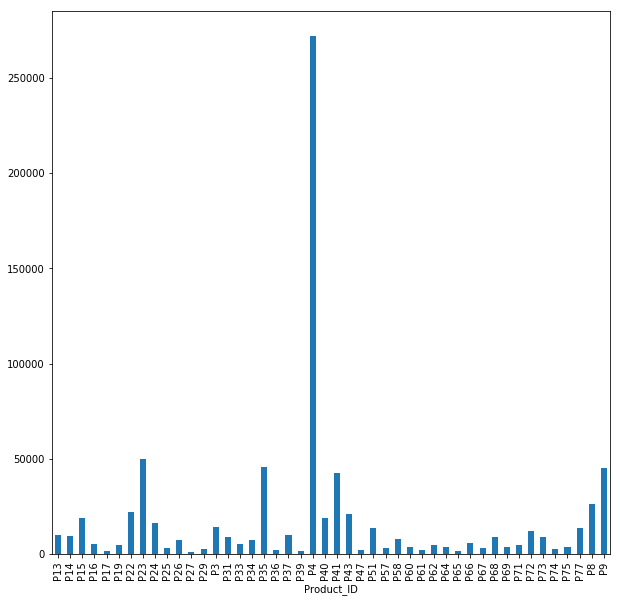

In [5]:
plt.figure(figsize=(10,10))
historical_demand.groupby('Product_ID').Demand.sum()[historical_demand.groupby('Product_ID').Demand.sum()!=0].plot(kind='bar')

In [6]:
changeover_cost.head(6)

,Plant,Line,Cost
0,A,1,33536.00
1,A,2,15947.00
2,B,1,13333.00
3,B,2,13333.00
4,B,3,13333.00
5,C,1,54353.39


In [7]:
print (changeover_days.Days.value_counts())
changeover_days.head()#when from=to days=0

10    2916
2     1207
1     1134
3      504
5      504
4      215
0       81
Name: Days, dtype: int64


,From,To,Days
0,P1,P1,0
1,P2,P1,1
2,P3,P1,1
3,P4,P1,1
4,P5,P1,1


In [163]:
demand_price.head()

,Product_ID,Region,Demand_price
0,P1,R1,0.0
1,P2,R1,0.0
2,P3,R1,0.0
3,P4,R1,0.0
4,P5,R1,0.0


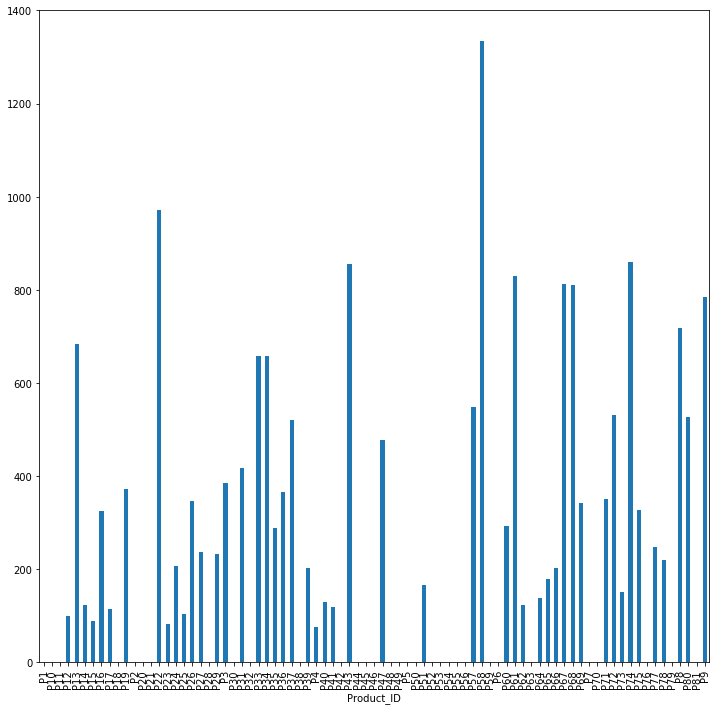

In [9]:
fig=plt.figure(figsize=(12,12))
demand_price.groupby('Product_ID').Demand_price.mean().plot('bar')

In [10]:
production_capacity.head()

,Plant,Line,Product,Capacity
0,A,1,P1,0
1,A,1,P2,0
2,A,1,P3,210
3,A,1,P4,0
4,A,1,P5,210


In [11]:
production_capacity.Capacity.describe()

count    486.000000
mean      41.454733
std       69.659740
min        0.000000
25%        0.000000
50%        0.000000
75%       75.000000
max      343.000000
Name: Capacity, dtype: float64

In [12]:
fixed_cost.head(6)

,Plant,Line,Cost
0,A,1,33536.00
1,A,2,15947.00
2,B,1,13333.00
3,B,2,13333.00
4,B,3,13333.00
5,C,1,54353.39


In [13]:
production_cost.head()

,Product_ID,Plant,Production_cost
0,P1,A,0.00
1,P2,A,0.00
2,P3,A,984.44
3,P4,A,0.00
4,P5,A,1358.41


In [14]:
delivery_cost.head()

,Plant,Region,Delivery_cost
0,A,R1,85.541475
1,A,R2,223.934332
2,A,R3,34.648618
3,A,R4,32.059332
4,A,R5,121.255760


In [15]:
print (test_demand.shape)
test_demand.head(5)

(4374, 4)


,Product_ID,Region,Month,Demand
0,P1,R1,37,NaN
1,P1,R1,38,NaN
2,P1,R1,39,NaN
3,P1,R10,37,NaN
4,P1,R10,38,NaN


In [16]:
print (test_seq.shape)
test_seq.head()

(540, 5)


,Plant,Line,Month,Day,Product_ID
0,A,1,37,1,NaN
1,A,1,37,2,NaN
2,A,1,37,3,NaN
3,A,1,37,4,NaN
4,A,1,37,5,NaN


In [17]:
print (test_ship.shape)
test_ship.head()

(13122, 5)


,Plant,Region,Product_ID,Month,Shipping_to_region_quantity
0,A,R1,P1,37,NaN
1,A,R1,P2,37,NaN
2,A,R1,P3,37,NaN
3,A,R1,P4,37,NaN
4,A,R1,P5,37,NaN


# Demand Forecast

In [182]:
historical_demand['year']=1
historical_demand.loc[(historical_demand.Month>=13),'year']=2
historical_demand.loc[(historical_demand.Month>=25),'year']=3
historical_demand['month_of_year']=historical_demand.Month
historical_demand.loc[historical_demand.year==2,'month_of_year']=historical_demand.Month-12
historical_demand.loc[historical_demand.year==3,'month_of_year']=historical_demand.Month-24
test_demand['year']=4
test_demand['month_of_year']=1
test_demand.loc[test_demand.Month==38,'month_of_year']=2
test_demand.loc[test_demand.Month==39,'month_of_year']=3

In [19]:
zero_demand=[]
zero_demand_id_number=[]
for i in range(1,82):
    if historical_demand[historical_demand.Product_ID=='P'+str(i)].Demand.sum()==0:
        zero_demand.append('P'+str(i))
        zero_demand_id_number.append(i)
#there are 35 products with no demand in any of the regions for last 36 months
print (len(zero_demand))

35


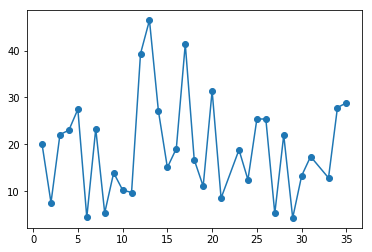

In [20]:
new=historical_demand[historical_demand.Product_ID=='P'+str(3)][(historical_demand\
    [historical_demand.Product_ID=='P'+str(3)].Demand!=0)]
plt.plot(new[new.Region=='R11'].Month,new[new.Region=='R11'].Demand,marker='o')

In [21]:
#region wise product demand:
not_all_zero=[]
for i in range(1,82):
    if i not in zero_demand_id_number:
        not_all_zero.append(i)
zero_pro_reg_demand=[]
for i in not_all_zero:
    for j in range(1,19):
        if (historical_demand[(historical_demand.Product_ID=='P'+str(i))&(historical_demand.Region=='R'+str(j))].Demand.sum())==0:
            tupl=(i,j)
            zero_pro_reg_demand.append(tupl)       

In [183]:
start=time.time() #forecasting demand based on separately for each product and region combination
for i in range(1,82):
    for j in range(1,19):
        train_data=historical_demand.loc[(historical_demand.Product_ID=='P'+str(i))&(historical_demand.Region=='R'+str(j))]
        X=train_data[['month_of_year','year']]
        y=train_data['Demand']
        xg1=XGBRegressor(n_estimators=1000,max_depth=3)
        xg1.fit(X,y)
        pred_xg1=xg1.predict(test_demand[(test_demand.Product_ID=='P'+str(i))&(test_demand.Region=='R'+str(j))][['month_of_year','year']])
        test_demand.loc[(test_demand.Product_ID=='P'+str(i))&(test_demand.Region=='R'+str(j)),'Demand']=pred_xg1   
end=time.time()
print (end-start)
test_demand['Demand']=np.round(test_demand.Demand)
#test_demand_month1=test_demand[test_demand.Month==37]
# test_demand_month2=test_demand[test_demand.Month==38]
# test_demand_month3=test_demand[test_demand.Month==39]

67.0927963256836


In [22]:
test_demand=pd.read_csv('/home/yash/Desktop/sample_av/demand_forecast.csv')
test_demand_month1=test_demand[test_demand.Month==37]
test_demand_month2=test_demand[test_demand.Month==38]
test_demand_month3=test_demand[test_demand.Month==39]

# Production

In [23]:
production_capacity['Product_ID']=production_capacity.Product.apply(lambda x:x.split('P')[1])
production_capacity['Product_ID']=production_capacity['Product_ID'].astype('int')
production_capacity=production_capacity.sort_values(['Product'])

In [24]:
#there are 13 products that are not produced in any plant,these are amongst the 35 products from zero_demand
non_zero_capacity=np.unique(production_capacity.sort_values('Product')[production_capacity.Capacity!=0].Product)

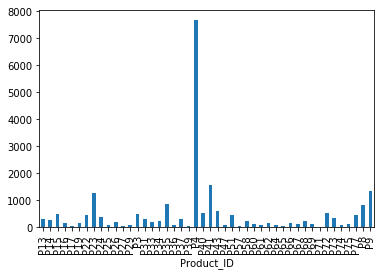

In [25]:
test_demand_month1.groupby('Product_ID').Demand.sum()[test_demand_month1.groupby('Product_ID').Demand.sum()!=0].plot(kind='bar')

In [26]:
most_demanded_product_1=pd.DataFrame(columns=['R'+str(i)for i in range(1,19)])
d=pd.DataFrame(columns=['D'+str(i)for i in range(1,19)])
most_demanded_product_1 =pd.concat([most_demanded_product_1,d],axis=1)             
for i in range(1,19):
    most_demanded_product_1['R'+str(i)]=test_demand_month1[test_demand_month1.Region=='R'+str(i)].sort_values('Demand',ascending=False).Product_ID.values
    most_demanded_product_1['D'+str(i)]=test_demand_month1[test_demand_month1.Region=='R'+str(i)].sort_values('Demand',ascending=False).Demand.values

In [27]:
production_capacity.set_index('Product',inplace=True)
production_capacity.drop(zero_demand,axis=0,inplace=True)
production_capacity.reset_index(inplace=True)
production_capacity.sort_values(['Product','Plant'],inplace=True)

In [28]:
#creating Dataframe for total demand of each product for month 1 :product_division
total_demand=test_demand_month1.set_index('Product_ID').drop(zero_demand,axis=0).reset_index().groupby('Product_ID').Demand.sum().values
product_name=test_demand_month1.set_index('Product_ID').drop(zero_demand,axis=0).reset_index().groupby('Product_ID').Demand.sum().index.values
product_division1=pd.DataFrame({'Product_Name':product_name,'Total_Demand':total_demand})

In [29]:
#creating Dataframe for total demand of each product for month 2&3 :product_division2,3
total_demand2=test_demand_month2.set_index('Product_ID').drop(zero_demand,axis=0).reset_index().groupby('Product_ID').Demand.sum().values
product_name2=test_demand_month2.set_index('Product_ID').drop(zero_demand,axis=0).reset_index().groupby('Product_ID').Demand.sum().index.values
product_division2=pd.DataFrame({'Product_Name':product_name2,'Total_Demand':total_demand2})
total_demand3=test_demand_month3.set_index('Product_ID').drop(zero_demand,axis=0).reset_index().groupby('Product_ID').Demand.sum().values
product_name3=test_demand_month3.set_index('Product_ID').drop(zero_demand,axis=0).reset_index().groupby('Product_ID').Demand.sum().index.values
product_division3=pd.DataFrame({'Product_Name':product_name3,'Total_Demand':total_demand3})

In [30]:
# product_plant=production_capacity.groupby(['Product','Plant']).Capacity.sum().index.values
# capacity_plant_wise=production_capacity.groupby(['Product','Plant']).Capacity.sum().values
# product_plant_capacity=[]
# for i in range(82):
#     a=list(product_plant[i])
#     a.append(capacity_plant_wise[i])
#     product_plant_capacity.append(a)  

In [31]:
production_cost.set_index('Product_ID',inplace=True)
production_cost.drop(zero_demand,axis=0,inplace=True)
production_cost.reset_index(inplace=True)
production_cost_sorted=production_cost.sort_values(['Product_ID','Plant'])

In [32]:
#adding production cost data to total demand of a product
final_Data=pd.DataFrame()
for i in np.unique(production_cost_sorted.Product_ID):
    a=production_cost_sorted[production_cost_sorted.Product_ID==i][['Product_ID','Plant','Production_cost']].values.flatten()
    new_data=pd.DataFrame({str(i):a})
    new_data=new_data.T
    final_Data=pd.concat([final_Data,new_data],axis=0)

In [33]:
product_wise_capacity=pd.DataFrame()
for i in np.unique(production_capacity.Product):
    a=production_capacity[production_capacity.Product==i][['Product','Plant','Line','Capacity']].values.flatten()
    new_data_1=pd.DataFrame({str(i):a})
    new_data_1=new_data_1.T
    product_wise_capacity=pd.concat([product_wise_capacity,new_data_1],axis=0)

In [34]:
final_Data.columns=['Product_A','Plant_A','A_Cost','Product_B','Plant_B','B_Cost','Product_C','Plant_C','C_Cost']
product_division1.set_index('Product_Name',inplace=True)
product_division1=pd.concat([product_division1,final_Data],axis=1)
product_division1.drop(['Product_A','Product_B','Product_C'],axis=1,inplace=True)
product_division2.set_index('Product_Name',inplace=True)
product_division2=pd.concat([product_division2,final_Data],axis=1)
product_division2.drop(['Product_A','Product_B','Product_C'],axis=1,inplace=True)
product_division3.set_index('Product_Name',inplace=True)
product_division3=pd.concat([product_division3,final_Data],axis=1)
product_division3.drop(['Product_A','Product_B','Product_C'],axis=1,inplace=True)

In [35]:
product_wise_capacity.drop([0,4,8,12,16,20,1,5,9,13,17,21,2,6,10,14,18,22],axis=1,inplace=True)
product_wise_capacity.columns=['A_1_capacity','A_2_capacity','B_1_capacity','B_2_capacity','B_3_capacity','C_1_capacity']
product_division1=pd.concat([product_division1,product_wise_capacity],axis=1)
product_division1.drop(['Plant_A','Plant_B','Plant_C'],axis=1,inplace=True)
product_division2=pd.concat([product_division2,product_wise_capacity],axis=1)
product_division2.drop(['Plant_A','Plant_B','Plant_C'],axis=1,inplace=True)
product_division3=pd.concat([product_division3,product_wise_capacity],axis=1)
product_division3.drop(['Plant_A','Plant_B','Plant_C'],axis=1,inplace=True)

In [36]:
#loading the maufacturing sequence ,which was created in excel
manufacture_sequence_real=pd.read_csv('/home/yash/Downloads/manufacture_sequence2.csv',index_col=None)

# Shipping

In [37]:
test_demand_month1['new']=test_demand_month1['Product_ID']+test_demand_month1['Region']
test_demand_month2['new']=test_demand_month2['Product_ID']+test_demand_month2['Region']
test_demand_month3['new']=test_demand_month3['Product_ID']+test_demand_month3['Region']
test_ship['new']=test_ship.Product_ID+test_ship.Region
test_demand_month1.sort_values('new',inplace=True)
test_demand_month2.sort_values('new',inplace=True)
test_demand_month3.sort_values('new',inplace=True)

In [38]:
test_ship1a=test_ship[(test_ship.Plant=='A')&(test_ship.Month==37)].sort_values('new')
test_ship1b=test_ship[(test_ship.Plant=='B')&(test_ship.Month==37)].sort_values('new')
test_ship1c=test_ship[(test_ship.Plant=='C')&(test_ship.Month==37)].sort_values('new')
test_ship2a=test_ship[(test_ship.Plant=='A')&(test_ship.Month==38)].sort_values('new')
test_ship2b=test_ship[(test_ship.Plant=='B')&(test_ship.Month==38)].sort_values('new')
test_ship2c=test_ship[(test_ship.Plant=='C')&(test_ship.Month==38)].sort_values('new')
test_ship3a=test_ship[(test_ship.Plant=='A')&(test_ship.Month==39)].sort_values('new')
test_ship3b=test_ship[(test_ship.Plant=='B')&(test_ship.Month==39)].sort_values('new')
test_ship3c=test_ship[(test_ship.Plant=='C')&(test_ship.Month==39)].sort_values('new')
test_ship1a['Demand']=test_demand_month1['Demand'].values
test_ship1b['Demand']=test_demand_month1['Demand'].values
test_ship1c['Demand']=test_demand_month1['Demand'].values
test_ship2a['Demand']=test_demand_month2['Demand'].values
test_ship2b['Demand']=test_demand_month2['Demand'].values
test_ship2c['Demand']=test_demand_month2['Demand'].values
test_ship3a['Demand']=test_demand_month3['Demand'].values
test_ship3b['Demand']=test_demand_month3['Demand'].values
test_ship3c['Demand']=test_demand_month3['Demand'].values
test_ship_new=pd.concat([test_ship1a,test_ship1b,test_ship1c,test_ship2a,test_ship2b,test_ship2c,test_ship3a,test_ship3b,test_ship3c],axis=0)

In [39]:
test_ship_new.head()

,Plant,Region,Product_ID,Month,Shipping_to_region_quantity,new,Demand
9,A,R1,P10,37,NaN,P10R1,0.0
738,A,R10,P10,37,NaN,P10R10,0.0
819,A,R11,P10,37,NaN,P10R11,0.0
900,A,R12,P10,37,NaN,P10R12,0.0
981,A,R13,P10,37,NaN,P10R13,0.0


In [40]:
produced_in_A=list(manufacture_sequence_real[manufacture_sequence_real.Plant=='A'].Product_ID.unique())
produced_in_B=list(manufacture_sequence_real[manufacture_sequence_real.Plant=='B'].Product_ID.unique())
produced_in_C=list(manufacture_sequence_real[manufacture_sequence_real.Plant=='C'].Product_ID.unique())

In [41]:
test_ship_new['Produced_in']=0
test_ship_new.loc[test_ship_new.Product_ID.isin(produced_in_A),'Produced_in']='A'
test_ship_new.loc[test_ship_new.Product_ID.isin(produced_in_B),'Produced_in']='B'
test_ship_new.loc[test_ship_new.Product_ID.isin(produced_in_C),'Produced_in']='C'
test_ship_new.sort_index(inplace=True)

In [42]:
test_ship_new['Delivery_cost']=0
for i in ['A','B','C']:
    for j in delivery_cost.Region.unique():
            test_ship_new.loc[(test_ship_new.Plant==i)&(test_ship_new.Region==j),'Delivery_cost']=delivery_cost[(delivery_cost.Plant==i)&(delivery_cost.Region==j)].Delivery_cost.values

In [43]:
test_ship_new['Demand_price']=0
for i in test_ship_new.Region.unique():
    for j in test_ship_new.Product_ID.unique():
        test_ship_new.loc[(test_ship_new.Region==i)&(test_ship_new.Product_ID==j),'Demand_price']=demand_price[(demand_price.Region==i)&(demand_price.Product_ID==j)].Demand_price.values

In [167]:
total_production=pd.read_excel('/home/yash/Downloads/manufacture_sequence2 _final.xlsx',sheetname=3)
total_production.reset_index(inplace=True)
total_production.drop('level_0',inplace=True,axis=1)
total_production.head()

,level_1,total,month 1,month2,month 3
0,P58,595,255,85,255
1,P74,70,70,0,0
2,P43,1430,520,390,520
3,P67,280,140,140,0
4,P9,3400,1200,1000,1200


In [73]:
test_ship_new['profit']=(test_ship_new['Demand_price']-test_ship_new['Delivery_cost'])*test_ship_new['Demand']
test_ship_new.loc[test_ship_new.profit<0,'profit']=0

In [168]:
test_ship_new['total_production']=0
for i in total_production.level_1.unique():
    for month,j in zip([37,38,39],['month 1','month2','month 3']):
        a=total_production[total_production.level_1==i][j].values[0]   
        test_ship_new.loc[((test_ship_new.Month==month)&(test_ship_new.Product_ID==i)),'total_production']=a                         

In [169]:
# test_ship_new['profit_normal']=0
# for i in total_production.level_1.unique():
#     for j in [37,38,39]:
#         profit_sum=test_ship_new[(test_ship_new.Plant==test_ship_new.Produced_in)&(test_ship_new.Month==j)&(test_ship_new.Product_ID==i)].profit.sum()
#         test_ship_new.loc[(test_ship_new.Plant==test_ship_new.Produced_in)&(test_ship_new.Month==j)&(test_ship_new.Product_ID==i),'profit_normal']=test_ship_new[(test_ship_new.Plant==test_ship_new.Produced_in)&(test_ship_new.Month==j)&(test_ship_new.Product_ID==i)].profit.values/profit_sum 
test_ship_new['Shipping_to_region_quantity']=test_ship_new['profit_normal']*test_ship_new['total_production']
test_ship_new['Shipping_to_region_quantity']=np.floor(test_ship_new['Shipping_to_region_quantity'])

In [170]:
test_ship=test_ship_new[['Plant','Region','Product_ID','Month','Shipping_to_region_quantity']]
test_ship.set_index('Plant',inplace=True)
# test_demand.set_index('Product_ID',inplace=True)
# manufacture_sequence_real.set_index('Plant',inplace=True)
# test_demand.to_csv('/home/yash/Desktop/av_submit/demand_forecast.csv')
#test_ship.to_csv('/home/yash/Desktop/av_submit/shipping_region.csv')
# manufacture_sequence_real.to_csv('/home/yash/Desktop/av_submit/manufacture_sequence.csv')

In [185]:
test_demand_final=test_demand[['Product_ID',"Region",'Month','Demand']]
test_demand_final.set_index('Product_ID',inplace=True)
test_demand_final.to_csv('/home/yash/Desktop/av_2/demand_forecast.csv')